In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Para evitar os vários warnings nos modelos KMeans (precisa ser executado antes de qualquer biblioteca)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    PowerTransformer, StandardScaler
)

from sklearn.pipeline import Pipeline
#from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

sns.set_theme(palette="bright")

from src.graficos import grafico_elbow_silhouette, visualizar_clusters_3d

RANDOM_STATE = 42

In [5]:
df = pd.read_csv("../dados/Mall_Customer_no_CustomerID.csv")
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [7]:
df.nunique()

Gender                     2
Age                       51
Annual Income (k$)        64
Spending Score (1-100)    84
dtype: int64

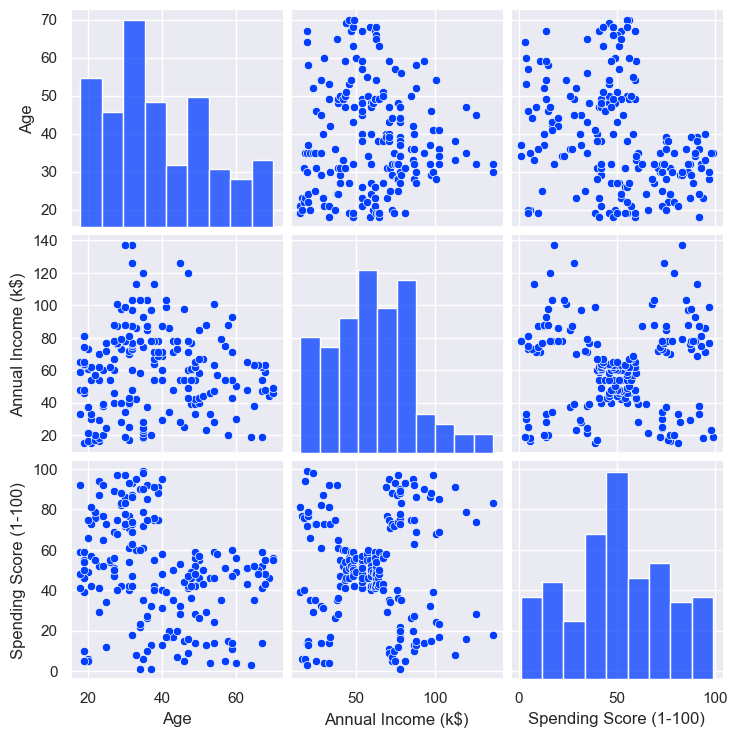

In [8]:
sns.pairplot(df)

#### Separando as colunas pelo tipo

In [9]:
colunas_categoricas = ['Gender']
colunas_numericas = df.drop(columns='Gender').columns

#### Definir Preprocessamento

In [10]:
preprocessamento = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), colunas_numericas),
        ('one_hot', OneHotEncoder(), colunas_categoricas),
    ], remainder= 'passthrough'
)

preprocessamento

ColumnTransformer(remainder='passthrough',
                  transformers=[('standard', StandardScaler(),
                                 Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                ('one_hot', OneHotEncoder(), ['Gender'])])

#### Analisando a transformação do dataframe após preprocessamento

In [11]:
df_preprocessado = pd.DataFrame(
    preprocessamento.fit_transform(df),
    columns=preprocessamento.get_feature_names_out()
)

df_preprocessado.head()

,standard__Age,standard__Annual Income (k$),standard__Spending Score (1-100),one_hot__Gender_Female,one_hot__Gender_Male
0,-1.424569,-1.738999,-0.434801,0.0,1.0
1,-1.281035,-1.738999,1.195704,0.0,1.0
2,-1.352802,-1.700830,-1.715913,1.0,0.0
3,-1.137502,-1.700830,1.040418,1.0,0.0
4,-0.563369,-1.662660,-0.395980,1.0,0.0


In [12]:
df_preprocessado.to_csv("../dados/Mall_Customers_scaled.csv")

#### Estudo para determinar número de Clusters (K)

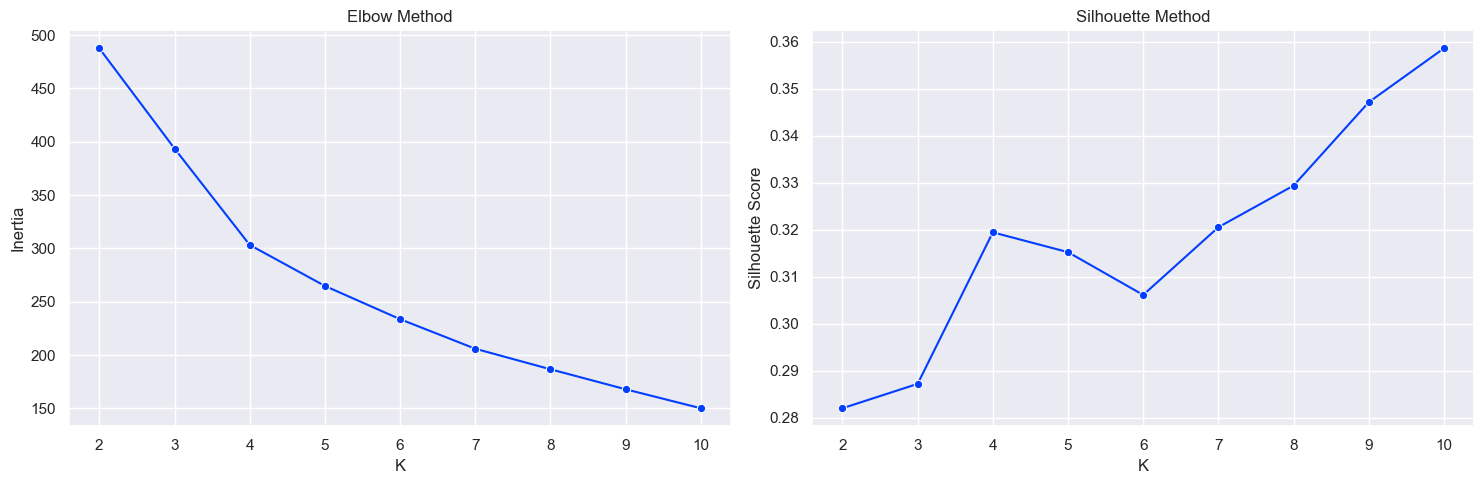

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), tight_layout=True)

elbow = {}
silhouette = []

X = df

k_range = range(2,11)

for numero in k_range:
    kmeans = Pipeline([
        ('preprocessamento', preprocessamento),
        ('kmeans', KMeans(n_clusters=numero, n_init= 10, random_state=RANDOM_STATE))   # n_init: é o número de vezes que o k-means é iniciado com diferentes centroides iniciais
    ])
    
    kmeans.fit(X)         

    elbow[numero] = kmeans['kmeans'].inertia_      # inertia_ : soma da distância quadrada de cada ponto para o centroide de seu cluster
    labels = kmeans['kmeans'].labels_              
    
    X_transformado = kmeans.named_steps['preprocessamento'].transform(X)
    silhouette.append(silhouette_score(X_transformado, labels))       
    # silhouete_score: dentro de cada cluster ele calcula a distância média de cada ponto, e compara com a distânia do ponto pro cluster mais próximo que ele não pertence

sns.lineplot( x = list(elbow.keys()), y = list(elbow.values()), ax=ax[0], marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('K')
ax[0].set_ylabel('Inertia')

sns.lineplot( x = list(k_range), y = silhouette, ax=ax[1], marker='o')
ax[1].set_title('Silhouette Method')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Silhouette Score')


plt.show()

**Conclusão:** Podemos usar K = 4 ou K = 5, vamos usar K=5 porque no pairplot ao cruzar os gráficos da pontuação com a renda anual já percebemos 5 grupos bem divididos

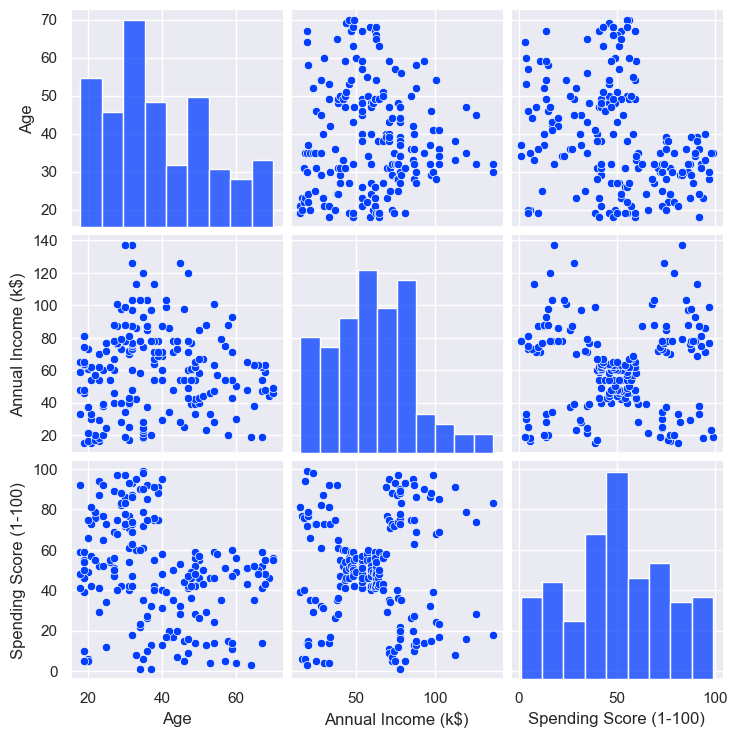

In [14]:
sns.pairplot(df)

#### Definir o modelo KMeans com o número de Clusters definido acima

In [15]:
pipeline = Pipeline([
    ('preprocessamento', preprocessamento),
    ('clustering', KMeans(n_clusters=5, n_init= 10, random_state=RANDOM_STATE))
])  

pipeline.fit(df)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard', StandardScaler(),
                                                  Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                                 ('one_hot', OneHotEncoder(),
                                                  ['Gender'])])),
                ('clustering',
                 KMeans(n_clusters=5, n_init=10, random_state=42))])

In [16]:
pipeline.named_steps

{'preprocessamento': ColumnTransformer(remainder='passthrough',
                   transformers=[('standard', StandardScaler(),
                                  Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                 ('one_hot', OneHotEncoder(), ['Gender'])]),
 'clustering': KMeans(n_clusters=5, n_init=10, random_state=42)}

#### Adicionando os clusters no dataframe original

In [17]:
pipeline['clustering'].labels_

array([4, 2, 4, 2, 4, 2, 4, 2, 1, 2, 1, 2, 1, 2, 4, 2, 4, 2, 1, 2, 4, 2,
       1, 2, 1, 2, 1, 2, 4, 2, 1, 2, 1, 2, 1, 2, 1, 2, 4, 2, 1, 2, 1, 4,
       1, 2, 1, 4, 4, 4, 1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 4,
       1, 1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 4, 4, 1, 1, 4, 1, 1, 4, 1, 1, 4,
       4, 1, 1, 4, 1, 4, 4, 4, 1, 4, 1, 4, 4, 1, 1, 4, 1, 4, 1, 1, 1, 1,
       1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 0, 4, 0, 3, 0, 3, 0, 3, 0,
       4, 0, 3, 0, 3, 0, 3, 0, 3, 0, 4, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 1, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0], dtype=int32)

In [18]:
df_clustered = df.copy()
df_clustered['cluster'] = pipeline['clustering'].labels_
df_clustered

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,4
1,Male,21,15,81,2
2,Female,20,16,6,4
3,Female,23,16,77,2
4,Female,31,17,40,4
...,...,...,...,...,...
195,Female,35,120,79,0
196,Female,45,126,28,3
197,Male,32,126,74,0
198,Male,32,137,18,3


In [19]:
df_clustered['cluster'].value_counts().sort_index()

# Para analisar a quantidade de clientes em cada cluster

cluster
0    39
1    58
2    22
3    34
4    47
Name: count, dtype: int64

In [20]:
df_clustered.groupby('cluster').describe().T

cluster                                0          1          2           3  \
Age                    count   39.000000  58.000000  22.000000   34.000000   
                       mean    32.692308  55.551724  25.272727   41.264706   
                       std      3.728650   8.324920   5.257030   10.768385   
                       min     27.000000  42.000000  18.000000   19.000000   
                       25%     30.000000  49.000000  21.250000   34.500000   
                       50%     32.000000  53.500000  23.500000   42.500000   
                       75%     35.500000  63.750000  29.750000   47.000000   
                       max     40.000000  70.000000  35.000000   59.000000   
Annual Income (k$)     count   39.000000  58.000000  22.000000   34.000000   
                       mean    86.538462  48.482759  25.727273   88.500000   
                       std     16.312485  13.797077   7.566731   16.533254   
                       min     69.000000  19.000000  15.000000   71.000000   
                       25%     75.500000  40.500000  19.250000   77.250000   
                       50%     79.000000  49.000000  24.500000   85.500000   
                       75%     95.000000  60.000000  32.250000   97.750000   
                       max    137.000000  79.000000  39.000000  137.000000   
Spending Score (1-100) count   39.000000  58.000000  22.000000   34.000000   
                       mean    82.128205  41.775862  79.363636   16.764706   
                       std      9.364489  15.658688  10.504174    9.881292   
                       min     63.000000   3.000000  61.000000    1.000000   
                       25%     74.500000  37.250000  73.000000   10.000000   
                       50%     83.000000  46.000000  77.000000   15.500000   
                       75%     90.000000  52.000000  85.750000   22.750000   
                       max     97.000000  60.000000  99.000000   39.000000   

cluster                               4  
Age                    count  47.000000  
                       mean   27.957447  
                       std     7.309783  
                       min    18.000000  
                       25%    21.000000  
                       50%    27.000000  
                       75%    34.500000  
                       max    40.000000  
Annual Income (k$)     count  47.000000  
                       mean   50.000000  
                       std    16.704595  
                       min    15.000000  
                       25%    40.000000  
                       50%    54.000000  
                       75%    62.000000  
                       max    76.000000  
Spending Score (1-100) count  47.000000  
                       mean   44.638298  
                       std    13.029107  
                       min     6.000000  
                       25%    40.000000  
                       50%    47.000000  
                       75%    54.500000  
                       max    61.000000

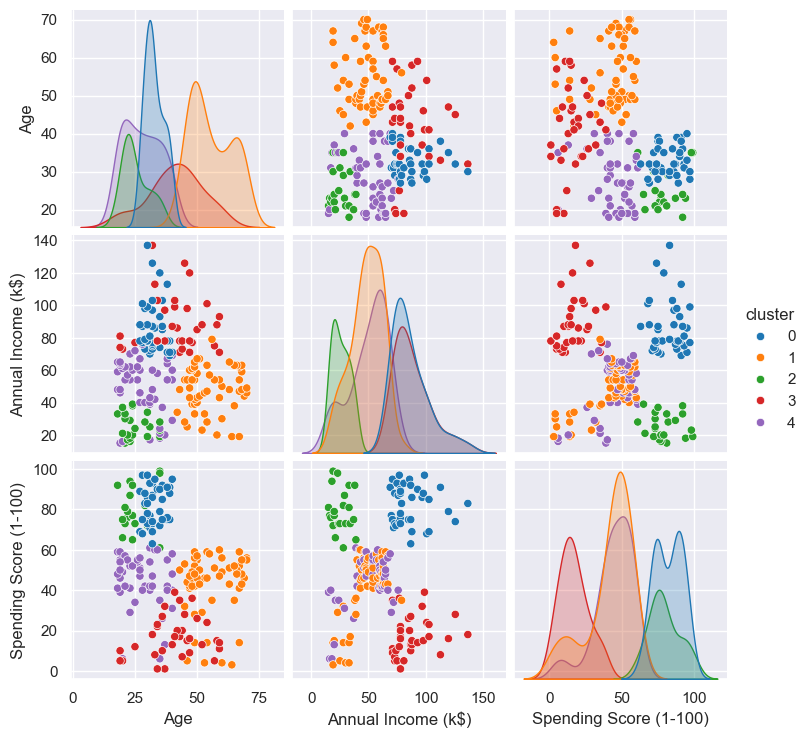

In [21]:
sns.pairplot(df_clustered, hue='cluster', palette='tab10')

[]

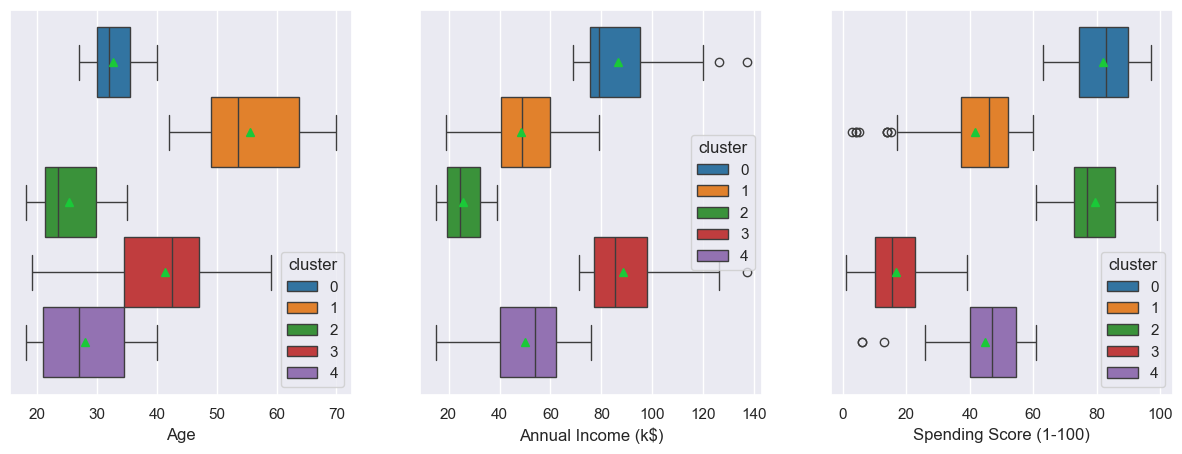

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)

for ax, coluna in zip(axs.flatten(), df_clustered.select_dtypes('number')):
    sns.boxplot(
        data=df_clustered, 
        x=coluna, 
        ax=ax, 
        showmeans=True, 
        hue='cluster',
        palette='tab10'
    )

plt.plot()  

#### **Definição dos Clusters**
- Cluster 0: idade jovem/adulto, renda alta, pontuação alta
- Cluster 1: adulto/idoso, renda moderada, pontuação moderada
- Cluster 2: jovem, renda baixa, pontuação alta 
- Cluster 3: Adulto, renda alta, pontuação baixa
- Cluster 4: jovem/adulto, renda moderada, pontuação moderada

Transformando os pontos acima em uma tabela

| Pontuação de Gastos | Renda | Idade | Cluster |
|---------------------|-------|-------|---------|
| Alta                | Alta  | Jovem/Adulto | 0       |
| Moderada            | Moderada | Adulto/Idoso | 1       |
| Alta                | Baixa | Jovem | 2       |
| Baixa               | Alta  | Adulto | 3       |
| Moderada            | Moderada | Jovem/Adulto | 4       |

OBS: Podemos entender se tem alguma variação entre generos.

#### Analisando as diferenças entre gênero

[]

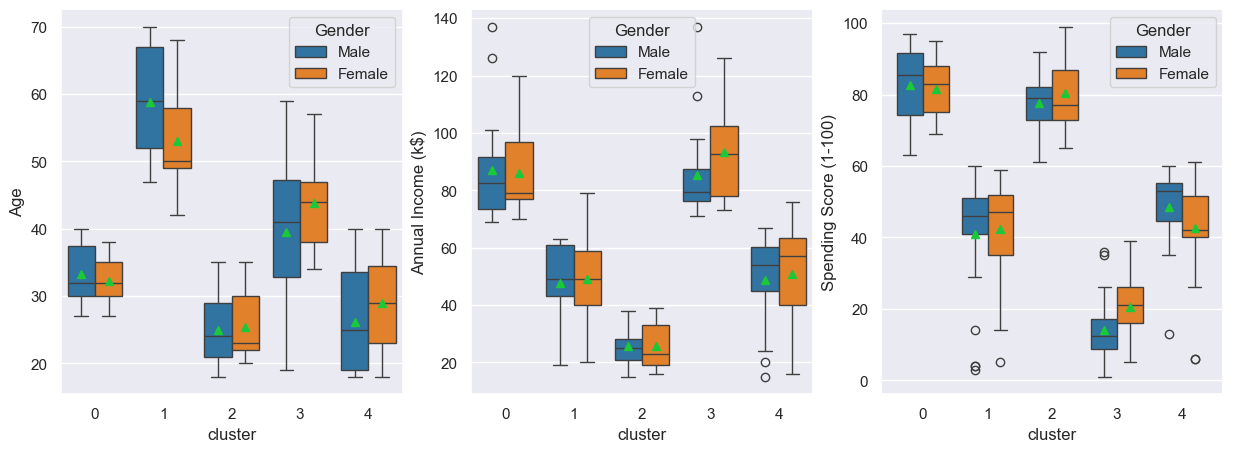

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for ax, coluna in zip(axs.flatten(), df_clustered.select_dtypes('number')):
    sns.boxplot(
        data=df_clustered, 
        x='cluster',
        y=coluna, 
        ax=ax, 
        showmeans=True, 
        hue='Gender',
        palette='tab10',
)

plt.plot()  

**OBS**: Nada muito significativo

In [24]:
df_clustered.groupby(by=['cluster', 'Gender']).size()

# Vejamos que os cluster até que estão bem distribuídos, não tem algum cluster que tem poucos dados de homem ou mulher só

cluster  Gender
0        Female    21
         Male      18
1        Female    33
         Male      25
2        Female    13
         Male       9
3        Female    14
         Male      20
4        Female    31
         Male      16
dtype: int64

#### Analisando os Cluster Graficamente

In [25]:
pipeline.named_steps

{'preprocessamento': ColumnTransformer(remainder='passthrough',
                   transformers=[('standard', StandardScaler(),
                                  Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')),
                                 ('one_hot', OneHotEncoder(), ['Gender'])]),
 'clustering': KMeans(n_clusters=5, n_init=10, random_state=42)}

In [26]:
pipeline['preprocessamento'].get_feature_names_out()

array(['standard__Age', 'standard__Annual Income (k$)',
       'standard__Spending Score (1-100)', 'one_hot__Gender_Female',
       'one_hot__Gender_Male'], dtype=object)

In [27]:
pipeline['clustering'].cluster_centers_

# A linha 1 corresponde o centroide do cluster 1 para cada um das 5 colunas do dataframe pós preprocessamento.
# A linha 2 corresponde o centroide do cluster 2 para cada um das 5 colunas do dataframe pós preprocessamento ....

array([[-0.44191719,  0.99158305,  1.23950275,  0.53846154,  0.46153846],
       [ 1.19862745, -0.46098141, -0.32703818,  0.56896552,  0.43103448],
       [-0.97439592, -1.32954532,  1.13217788,  0.59090909,  0.40909091],
       [ 0.17329545,  1.06645385, -1.2980103 ,  0.41176471,  0.58823529],
       [-0.78172248, -0.40306917, -0.21591396,  0.65957447,  0.34042553]])

In [ ]:
pipeline['clustering'].cluster_centers_[:, :-2]       

# Pegando a informação dos centroides acima, 
# Mantendo todas as linhas (informação dos clusters)
# Eliminando as colunas da direita (que corresponde a posição dos centroides de cada cluster para a coluna one_hot_Gender_Male e one_hot_Gender_Female)

array([[-0.44191719,  0.99158305,  1.23950275],
       [ 1.19862745, -0.46098141, -0.32703818],
       [-0.97439592, -1.32954532,  1.13217788],
       [ 0.17329545,  1.06645385, -1.2980103 ],
       [-0.78172248, -0.40306917, -0.21591396]])

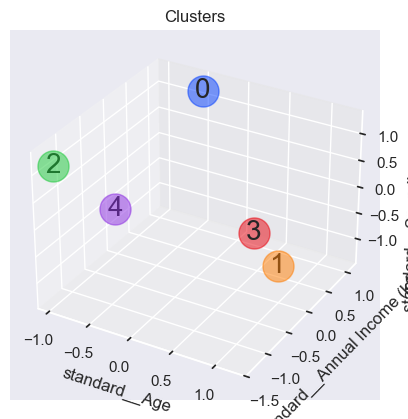

In [ ]:
from src.graficos import visualizar_clusters_3d

centroides = pipeline['clustering'].cluster_centers_[:, :-2]  

visualizar_clusters_3d(
    df_preprocessado,  
    colunas=['standard__Age',
             'standard__Annual Income (k$)',
             'standard__Spending Score (1-100)'],
    
    quantidade_cores_clusters=5,
    centroids=centroides,
    mostrar_centroids=True,
    mostrar_pontos=False,
)

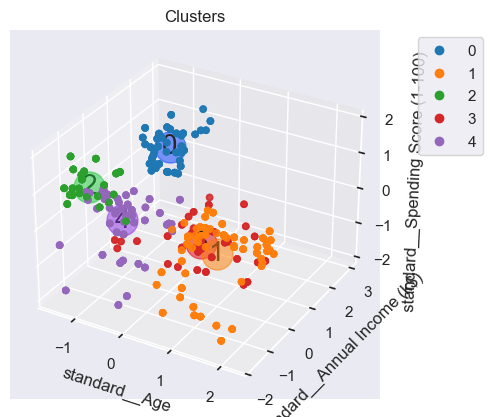

In [ ]:
centroides = pipeline['clustering'].cluster_centers_[:, :-2]  

visualizar_clusters_3d(
    df_preprocessado,        
    colunas=['standard__Age',
             'standard__Annual Income (k$)',
             'standard__Spending Score (1-100)'],
    
    quantidade_cores_clusters=5,
    centroids=centroides,
    mostrar_centroids=True,
    mostrar_pontos=True,
    coluna_clusters=df_clustered['cluster']
)

#### Gráficos 2d

In [31]:
df_preprocessado.head(3)

,standard__Age,standard__Annual Income (k$),standard__Spending Score (1-100),one_hot__Gender_Female,one_hot__Gender_Male
0,-1.424569,-1.738999,-0.434801,0.0,1.0
1,-1.281035,-1.738999,1.195704,0.0,1.0
2,-1.352802,-1.700830,-1.715913,1.0,0.0


In [32]:
centroids = pipeline['clustering'].cluster_centers_
centroids

array([[-0.44191719,  0.99158305,  1.23950275,  0.53846154,  0.46153846],
       [ 1.19862745, -0.46098141, -0.32703818,  0.56896552,  0.43103448],
       [-0.97439592, -1.32954532,  1.13217788,  0.59090909,  0.40909091],
       [ 0.17329545,  1.06645385, -1.2980103 ,  0.41176471,  0.58823529],
       [-0.78172248, -0.40306917, -0.21591396,  0.65957447,  0.34042553]])

In [33]:
print(centroids[:, 0])     # Posição dos centroides de cada cluster para a coluna 'Age'
print(centroids[:, 1])     # Posição dos centroides de cada cluster para a coluna 'Annual Income'
print(centroids[:, 2])     # Posição dos centroides de cada cluster para a coluna 'Spending Score'
print(centroids[:, 3])     # Posição dos centroides de cada cluster para a coluna 'Gender_Female'
print(centroids[:, 4])     # Posição dos centroides de cada cluster para a coluna 'Gender_Male'

[-0.44191719  1.19862745 -0.97439592  0.17329545 -0.78172248]
[ 0.99158305 -0.46098141 -1.32954532  1.06645385 -0.40306917]
[ 1.23950275 -0.32703818  1.13217788 -1.2980103  -0.21591396]
[0.53846154 0.56896552 0.59090909 0.41176471 0.65957447]
[0.46153846 0.43103448 0.40909091 0.58823529 0.34042553]


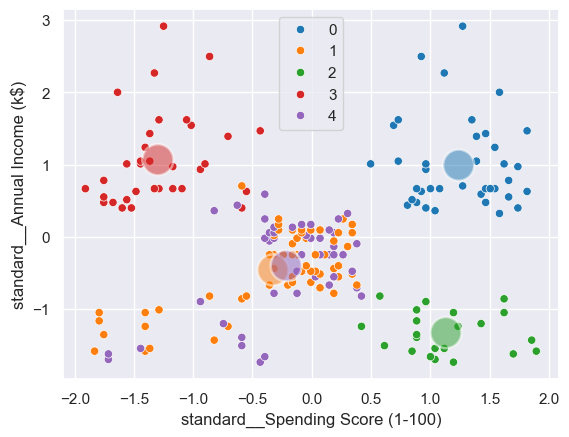

In [34]:
fig, ax = plt.subplots()

Age, Annual_Income, Spending_Score, Gender_Female, Gender_Male = df_preprocessado.columns

centroids = pipeline['clustering'].cluster_centers_

sns.scatterplot(
    x=Spending_Score,
    y=Annual_Income,
    data=df_preprocessado,
    hue=df_clustered['cluster'],
    palette='tab10'
)

numero_clusters = 5
cores_centroides = sns.color_palette('tab10', numero_clusters)

sns.scatterplot(
    x=centroids[:, 2],        # Consultar conforme tabela acima qual é a posição da coluna 'x' na variável 'centroids'
    y=centroids[:, 1],        # Consultar conforme tabela acima qual é a posição da coluna 'y' na variável 'centroids'
    color = cores_centroides,
    marker='o',
    s=500,
    ax=ax,
    alpha=0.5
)

plt.show()

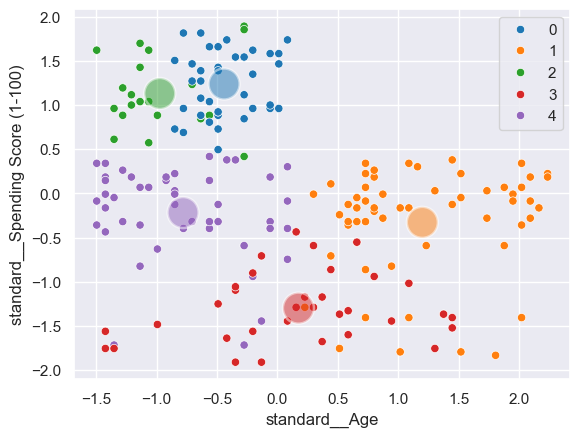

In [35]:
fig, ax = plt.subplots()

Age, Annual_Income, Spending_Score, Gender_Female, Gender_Male = df_preprocessado.columns

centroids = pipeline['clustering'].cluster_centers_

sns.scatterplot(
    x=Age,
    y=Spending_Score,
    data=df_preprocessado,
    hue=df_clustered['cluster'],
    palette='tab10'
)

numero_clusters = 5
cores_centroides = sns.color_palette('tab10', numero_clusters)

sns.scatterplot(
    x=centroids[:, 0],        # Consultar conforme tabela acima qual é a posição da coluna 'x' na variável 'centroids'
    y=centroids[:, 2],        # Consultar conforme tabela acima qual é a posição da coluna 'y' na variável 'centroids'
    color = cores_centroides,
    marker='o',
    s=500,
    ax=ax,
    alpha=0.5
)

plt.show()

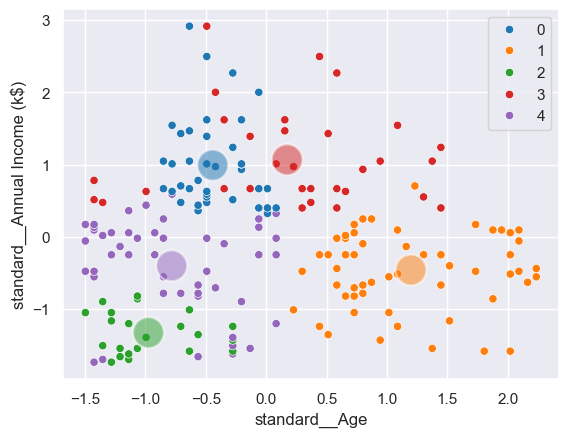

In [37]:
fig, ax = plt.subplots()

Age, Annual_Income, Spending_Score, Gender_Female, Gender_Male = df_preprocessado.columns

centroids = pipeline['clustering'].cluster_centers_

sns.scatterplot(
    x=Age,
    y=Annual_Income,
    data=df_preprocessado,
    hue=df_clustered['cluster'],
    palette='tab10'
)

numero_clusters = 5
cores_centroides = sns.color_palette('tab10', numero_clusters)

sns.scatterplot(
    x=centroids[:, 0],        # Consultar conforme tabela acima qual é a posição da coluna 'x' na variável 'centroids'
    y=centroids[:, 1],        # Consultar conforme tabela acima qual é a posição da coluna 'y' na variável 'centroids'
    color = cores_centroides,
    marker='o',
    s=500,
    ax=ax,
    alpha=0.5
)

plt.show()

#### Analisando graficamente dados originais separados por clusters

In [39]:
df_clustered

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,4
1,Male,21,15,81,2
2,Female,20,16,6,4
3,Female,23,16,77,2
4,Female,31,17,40,4
...,...,...,...,...,...
195,Female,35,120,79,0
196,Female,45,126,28,3
197,Male,32,126,74,0
198,Male,32,137,18,3


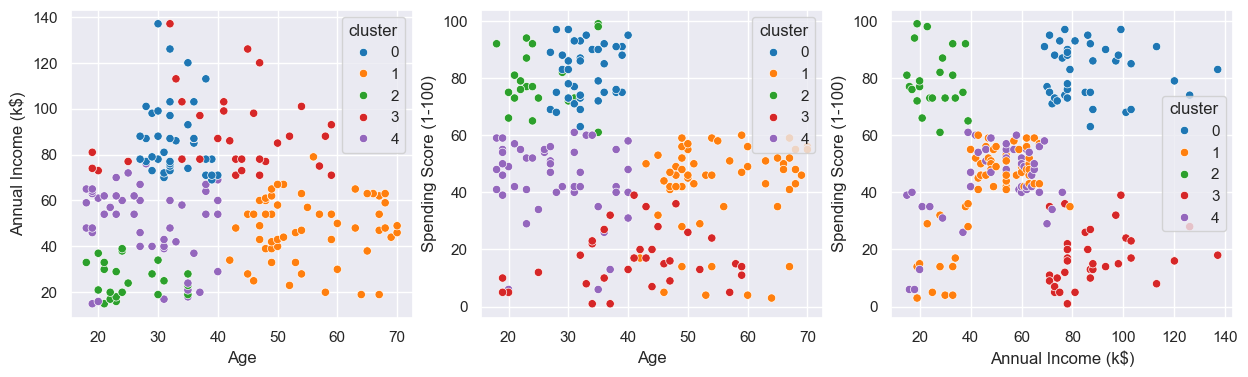

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

Gender, Age, Annual_Income, Spending_Score, cluster = df_clustered.columns

sns.scatterplot(
    x=Age,
    y=Annual_Income,
    data=df_clustered,
    hue=df_clustered['cluster'],
    palette='tab10',
    ax=axs[0]
)

sns.scatterplot(
    x=Age,
    y=Spending_Score,
    data=df_clustered,
    hue=df_clustered['cluster'],
    palette='tab10',
    ax=axs[1]
)

sns.scatterplot(
    x=Annual_Income,
    y=Spending_Score,
    data=df_clustered,
    hue=df_clustered['cluster'],
    palette='tab10',
    ax=axs[2]
)

#plt.set_suptitle('Análise Gráfica dos Clusters na base original')

plt.show()


#### Exportando o modelo

In [36]:
import joblib

joblib.dump(pipeline, "../modelos/pipeline_preprocessamento_clustering.pkl")

['../modelos/pipeline_preprocessamento_clustering.pkl']